https://github.com/KrisHan999/Faster-RCNN_from_scratch/blob/master/utils.py 를 참고했습니다.

In [88]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms

## Faster R-CNN의 training 흐름



1. pre-trained된 모델(VGC 16)에 원본 이미지를 입력하여 feature map을 얻는다.

2. VGC 16으로부터 feature map을 입력받아 원본 이미지에 대하여 생성한 각 anchor box에 대한 class score, bounding box regressor를 얻는다.(RPN)

3. class score, bounding box regressor를 통해 region proposals를 추출한다. (Non Maximum Supperssion(NMS)기법으로 부적절한 anchor box를 걸러냄)

4. IoU값을 통해서 RPN이 학습하는데 사용할 anchor를 선택한다.(RPN)

5. 3번에서 얻은 region proposals를 feature map에 RoI pooling을 한다.(Fast R-CNN)

6. 출력된 결과를 사용하여 multi-task loss를 통해 Fast R-CNN모델을 학습시킨다.

7. 4번에서 얻은 anchor를 RPN에 다시 학습하여 region proposals를 추출하고 이를 다시 Fast R-CNN을 학습시킨다.

# 계산에 필요한 함수 생성

bbox_IoU : 각 bbox들의 IoU 값을 계산하는 함수

format_loc : 각 anchor box에 대해 bbox의 bounding box regressor를 구하기 위한 함수

deformat_loc : bounding box regressor의 결과와 앵커 박스를 통해 예측 경계 박스의 좌표를 얻기 위한 함수

nms : NMS를 위한 함수


In [89]:
# 각 bbox의 IoU 값 계산
# bboxes_1 : anchor N 개
# bboxes_2 : target box n 개
def bbox_IoU(bboxes_1, bboxes_2) :
    len_bboxes_1 = bboxes_1.shape[0] # N
    len_bboxes_2 = bboxes_2.shape[0] # n
    IoUs = np.zeros((len_bboxes_1, len_bboxes_2))

    for idx, bbox_1 in enumerate(bboxes_1) : # bbox : (y1, x1, y2, x2), N개
        # (1,n) shape의 array 형성
        yy1_max = np.maximum(bbox_1[0], bboxes_2[:, 0])
        xx1_max = np.maximum(bbox_1[1], bboxes_2[:, 1])
        yy2_min = np.minimum(bbox_1[2], bboxes_2[:, 2])
        xx2_min = np.minimum(bbox_1[3], bboxes_2[:, 3])
        # 겹치는 영역의 사각형의 넓이
        height = np.maximum(0.0, yy2_min - yy1_max)
        width = np.maximum(0.0, xx2_min - xx1_max) 
        inter = height * width
        
        eps = np.finfo(np.float32).eps # union으로 나눌 때, 0이 되는 것을 방지
        union = (bbox_1[2] - bbox_1[0]) * (bbox_1[3] - bbox_1[1]) + \
            (bboxes_2[:, 2] - bboxes_2[:, 0]) * (bboxes_2[:, 3] - bboxes_2[:, 1]) - inter + eps
        IoU = inter / union
        IoUs[idx] = IoU
    
    return IoUs # shape : (N,n)


'''
t_{x} = (x - x_{a})/w_{a}
t_{y} = (y - y_{a})/h_{a}
t_{w} = log(w/ w_a)
t_{h} = log(h/ h_a)
'''
# bounding box regressor를 구하기 위함
# anchors : 앵커 박스 x_a, x*
# base_anchors : 예측 경계 박스 x
def format_loc(anchors, base_anchors):
    # (x,y), (x_{a},y_{a}) 는 x와 x_a의 중심 좌표
    # x, x_a(x*)는 각각 예측 경계 박스와 앵커 박스(실제 경계 박스)
    height = anchors[:, 2] - anchors[:, 0]
    width = anchors[:, 3] - anchors[:, 1]
    ctr_y = anchors[:, 0] + height*0.5
    ctr_x = anchors[:, 1] + width*0.5

    base_height = base_anchors[:, 2] - base_anchors[:, 0]
    base_width = base_anchors[:, 3] - base_anchors[:, 1]
    base_ctr_y = base_anchors[:, 0] + base_height*0.5
    base_ctr_x = base_anchors[:, 1] + base_width*0.5

    eps = np.finfo(np.float32).eps # height와 weight으로 나눌 때, 0이 되는 것을 방지
    height = np.maximum(eps, height)
    width = np.maximum(eps, width)

    dy = (base_ctr_y - ctr_y) / height
    dx = (base_ctr_x - ctr_x) / width
    dh = np.log(base_height / height)
    dw = np.log(base_width / width)

    anchor_loc_target = np.stack((dy, dx, dh, dw), axis=1)
    return anchor_loc_target

# (dy, dx, dh, dw) & (y, x, h, w) -> (y1, x1, y2, x2)
# bounding box regressor의 결과와 앵커 박스를 통해 예측 경계 박스의 좌표를 얻기 위함
def deformat_loc(anchors, formatted_base_anchor):
    # anchor의 중심좌표와 높이, 넓이 즉, (x,y,h,w) 좌표 얻기
    height = anchors[:, 2] - anchors[:, 0]
    width = anchors[:, 3] - anchors[:, 1]
    ctr_y = anchors[:, 0] + height*0.5
    ctr_x = anchors[:, 1] + width*0.5
    
    dy, dx, dh, dw = formatted_base_anchor.T # (1,9) -> (9,1)로 변환 (ㅔ인 이유는 anchor 박스가 9개이기 때문)
    # 기존 계산식을 역산하여 예측 bbox의 (x,y,h,w) 좌표 얻기
    base_height = np.exp(dh) * height
    base_width = np.exp(dw) * width
    base_ctr_y = dy * height + ctr_y
    base_ctr_x = dx * width + ctr_x
    
    base_anchors = np.zeros_like(anchors)
    # 중심 좌표로 부터 h, w를 이용하여 꼭짓점 좌표 구하기
    base_anchors[:, 0] = base_ctr_y - base_height*0.5
    base_anchors[:, 1] = base_ctr_x - base_width*0.5
    base_anchors[:, 2] = base_ctr_y + base_height*0.5
    base_anchors[:, 3] = base_ctr_x + base_width*0.5
    
    return base_anchors

# NMS(Non-maximum supperssion)
# rois : bounding box의 집합 (N,4) -> N개
# socres : bounding box의 class socre (N,)
# threshold : 임계치
def nms(rois, scores, threshold):
    order = scores.argsort()[::-1] # score가 큰 순서대로 index 정렬
    y1, x1, y2, x2 = rois.T # 
    
    keep_index = [] # 최종적으로 남길 bounding box index를 담을 list
    
    while order.size > 0:
        i = order[0] # 가장 큰 socre의 index 저장
        keep_index.append(i) 
        # np.newaxis를 통해 (4,)를 (1,4)로 변환
        IoUs = bbox_IoU(rois[i][np.newaxis, :], rois[order[1:]]) # -> (1, N-1)
        inds = np.where(IoUs <= threshold)[1] # (1, P)이므로 [1]을 통해 index 전달
        order = order[inds + 1] 
        # 가장 큰 값의 idx를 제외하고 계산한 결과 이기 때문에
        # 원래 idx를 찾기 위해 1을 더함
    return keep_index

## Feature Extraction

In [90]:
image = torch.zeros((1, 3, 800, 800)).float()

# [y1, x1, y2, x2] format
bbox = torch.FloatTensor([[20, 30, 400, 500], [300, 400, 500, 600]])
labels = torch.LongTensor([6, 8])

# 1x1 in feature map -> 16x16 in image
sub_sample = 16

In [91]:
dummy_img = torch.zeros((1, 3, 800, 800)).float()
print(dummy_img.size())

torch.Size([1, 3, 800, 800])


## VGG16 to exact features

Because there are 4 maxpooling layers, (H, W) -> (H//16, W//16)

In [92]:
VGG16 = models.vgg16(pretrained=True)
req_features = VGG16.features[:30]

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [93]:
faster_rcnn_feature = nn.Sequential(*req_features)

Sample output

In [94]:
output_map = faster_rcnn_feature(dummy_img)
print(output_map.shape)

torch.Size([1, 512, 50, 50])


## Anchor boxes

논문에서는 9개(크기 3 x 비율 3)의 anchor box를 만들었고, 각 좌표를 (y1, x1, y2, x2)로 표현한다. anchor size는 [8, 16, 32]로 정하고 그 비율은 [0.5, 1, 2]로 한다.

In [95]:
a = np.array([[[1,2]]])
print(a.shape)
b = np.array([[4,4,4,4]])

(1, 1, 2)


In [96]:
a[0,0] + b.reshape(-1,2,2)

array([[[5, 6],
        [5, 6]]])

In [97]:
# ration = h/w
ratio = [0.5, 1, 2]
# anchor_size
anchor_size = [8, 16, 32]

len_anchor_scale = len(anchor_size)
len_ratio = len(ratio)
len_anchor_template = len_anchor_scale * len_ratio
anchor_template = np.zeros((9, 4))

for idx, scale in enumerate(anchor_size):
    h = scale * np.sqrt(ratio) * sub_sample
    w = scale / np.sqrt(ratio) * sub_sample
    y1 = -h/2
    x1 = -w/2
    y2 = h/2
    x2 = w/2
    anchor_template[idx*len_ratio:(idx+1)*len_ratio, 0] = y1
    anchor_template[idx*len_ratio:(idx+1)*len_ratio, 1] = x1
    anchor_template[idx*len_ratio:(idx+1)*len_ratio, 2] = y2
    anchor_template[idx*len_ratio:(idx+1)*len_ratio, 3] = x2

print(anchor_template)

[[ -45.254834    -90.50966799   45.254834     90.50966799]
 [ -64.          -64.           64.           64.        ]
 [ -90.50966799  -45.254834     90.50966799   45.254834  ]
 [ -90.50966799 -181.01933598   90.50966799  181.01933598]
 [-128.         -128.          128.          128.        ]
 [-181.01933598  -90.50966799  181.01933598   90.50966799]
 [-181.01933598 -362.03867197  181.01933598  362.03867197]
 [-256.         -256.          256.          256.        ]
 [-362.03867197 -181.01933598  362.03867197  181.01933598]]


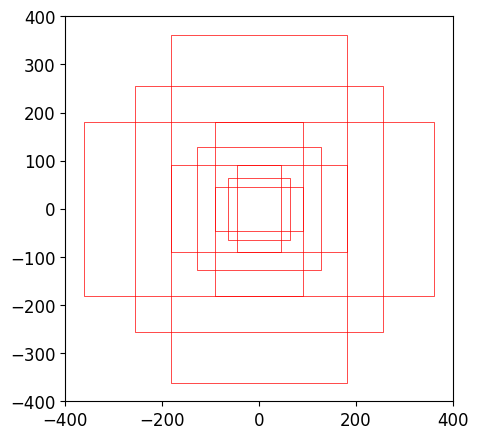

In [98]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.style.use('default')
plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['font.size'] = 12

fig, ax = plt.subplots()

# anchor box 시각화
for (y1, x1, y2, x2) in anchor_template:
    x, y = x1, y1
    w = 2*x2
    h = 2*y2
    ax.add_patch(
        patches.Rectangle(
            (x, y), w, h,
            edgecolor='red',
            linewidth=0.5,
            fill=False))

ax.set_xlim(-400, 400)
ax.set_ylim(-400, 400)
plt.show()

In [99]:
feature_map_size = (50, 50)
# The first center coors is (8, 8)
ctr_y = np.arange(8, 800, 16)
ctr_x = np.arange(8, 800, 16)

# anchor_template이 위치할 점들
ctr = np.zeros((*feature_map_size, 2))
for idx, y in enumerate(ctr_y):
    ctr[idx, :, 0] = y
    ctr[idx, :, 1] = ctr_x

anchors = np.zeros((*feature_map_size, 9, 4))
# 점들에 대한 각각의 anchor template
for idx_y in range(feature_map_size[0]):
    for idx_x in range(feature_map_size[1]):
        anchors[idx_y, idx_x] = (ctr[idx_y, idx_x] + anchor_template.reshape(-1, 2, 2)).reshape(-1, 4)

anchors = anchors.reshape(-1, 4)

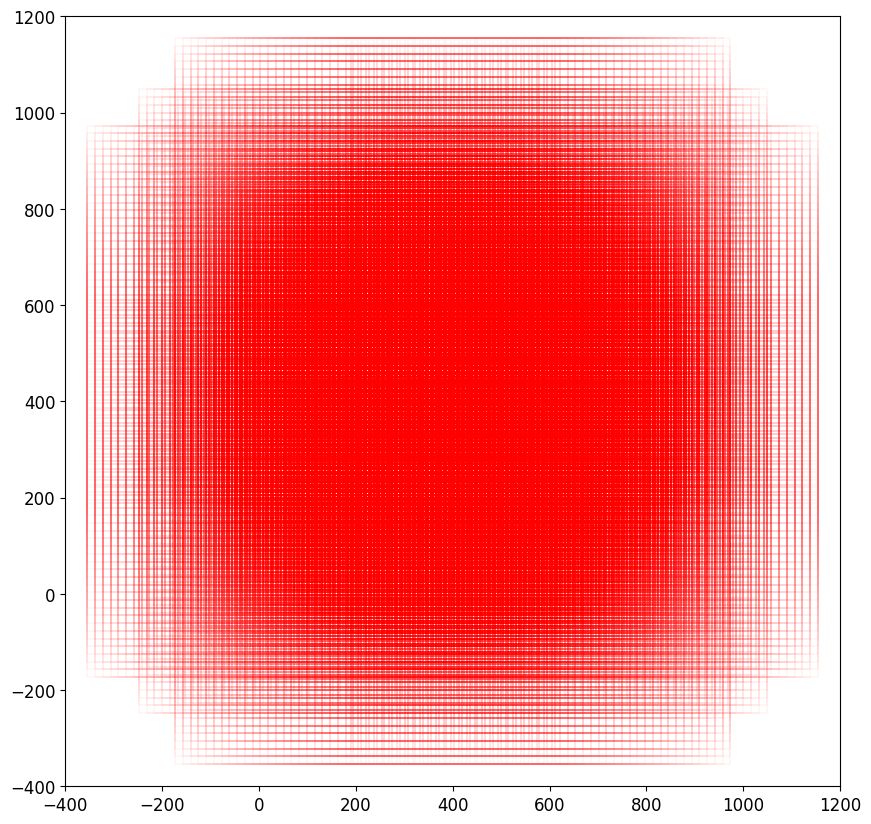

In [100]:
# 적용된 anchor template 시각화
# 50x50x9(22500개)의 anchor box
plt.rcParams['figure.figsize'] = (10, 10)
fig, ax = plt.subplots()

for (y1, x1, y2, x2) in anchors:
    x, y = x1, y1
    w = np.abs(x2 - x1)
    h = np.abs(y2 - y1)
    ax.add_patch(
        patches.Rectangle(
            (x, y), w, h,
            edgecolor='red',
            linewidth=0.05,
            fill=False))

ax.set_xlim(-400, 1200)
ax.set_ylim(-400, 1200)
plt.show()

### RPN을 위한 Anchor Box labeling

In [101]:
# 이미지를 넘어가는 박스 제외(800x800)
valid_index = np.where((anchors[:, 0] >= 0)
                      &(anchors[:, 1] >= 0)
                      &(anchors[:, 2] <= 800)
                      &(anchors[:, 3] <= 800))[0]
print(valid_index.shape) # 8940

(8940,)


In [102]:
# RPN에서는 Region Proposal의 목적이 있기 때문에 여러개의 propesal 중
# 겹치는 것과 불필요한 것들을 제거하기 위해 -1 label을 할당
valid_labels = np.empty((valid_index.shape[0],), dtype=np.int32)
valid_labels.fill(-1)

valid_anchors = anchors[valid_index]

print(valid_anchors.shape) # (8940,4)
print(bbox.shape) # torch.Size([2,4])

(8940, 4)
torch.Size([2, 4])


In [103]:
ious = bbox_IoU(valid_anchors, bbox.numpy()) # anchor 8940 : bbox 2

# 실제
# pos_iou_threshold = 0.7
# neg_iou_threshold = 0.3

# 실험을 위한 설정 (실제대로 적용하면 rpn loss 가 측정 불가됨)
pos_iou_threshold = 0.55
neg_iou_threshold = 0.3

# 0.7 이상이면 positive, 0.3보다 작으면 negative를 레이블
anchor_max_iou = np.amax(ious, axis=1)
pos_iou_anchor_label = np.where(anchor_max_iou >= pos_iou_threshold)[0]
neg_iou_anchor_label = np.where(anchor_max_iou < neg_iou_threshold)[0]
valid_labels[pos_iou_anchor_label] = 1
valid_labels[neg_iou_anchor_label] = 0

In [104]:
n_sample_anchors = 256 # pos, neg 를 합쳐서 n_sample_anchors만 남기고 제외
pos_ratio = 0.5 # 남길 pos의 비율, neg -> (1 - pos_ratio)

total_n_pos = len(np.where(valid_labels == 1)[0])
n_pos_sample = n_sample_anchors*pos_ratio if total_n_pos > n_sample_anchors*pos_ratio else total_n_pos
n_neg_sample = n_sample_anchors - n_pos_sample

pos_index = np.where(valid_labels == 1)[0]
if len(pos_index) > n_sample_anchors*pos_ratio:
    disable_index = np.random.choice(pos_index, size=len(pos_index)-n_pos_sample, replace=False)
    # 제거할 부분을 -1로 labeling
    valid_labels[disable_index] = -1 # 임의 추출로 남길 pos 수보다 많은 정도를 제거

neg_index = np.where(valid_labels == 0)[0]
disable_index = np.random.choice(neg_index, size=len(neg_index) - n_neg_sample, replace=False)
valid_labels[disable_index] = -1 # 임의 추출로 남길 neg 수보다 많은 정도를 제거

In [105]:
argmax_iou = np.argmax(ious, axis=1)
max_iou_box = bbox[argmax_iou].numpy() # 각 anchor 별로 가장 높은 iou를 가진 bbox 좌표
print(max_iou_box.shape) # 8940, 4
print(valid_anchors.shape) # 8940, 4

anchor_loc_format_target = format_loc(valid_anchors, max_iou_box)
print(anchor_loc_format_target.shape) # 8940, 4

(8940, 4)
(8940, 4)
(8940, 4)


In [106]:
anchor_target_labels = np.empty((len(anchors),), dtype=np.int32)
anchor_target_format_locations = np.zeros((len(anchors), 4), dtype=np.float32)

anchor_target_labels.fill(-1)
anchor_target_labels[valid_index] = valid_labels

anchor_target_format_locations[valid_index] = anchor_loc_format_target

print(anchor_target_labels.shape) # 22500,
print(anchor_target_format_locations.shape) # 22500, 4

(22500,)
(22500, 4)


## RPN

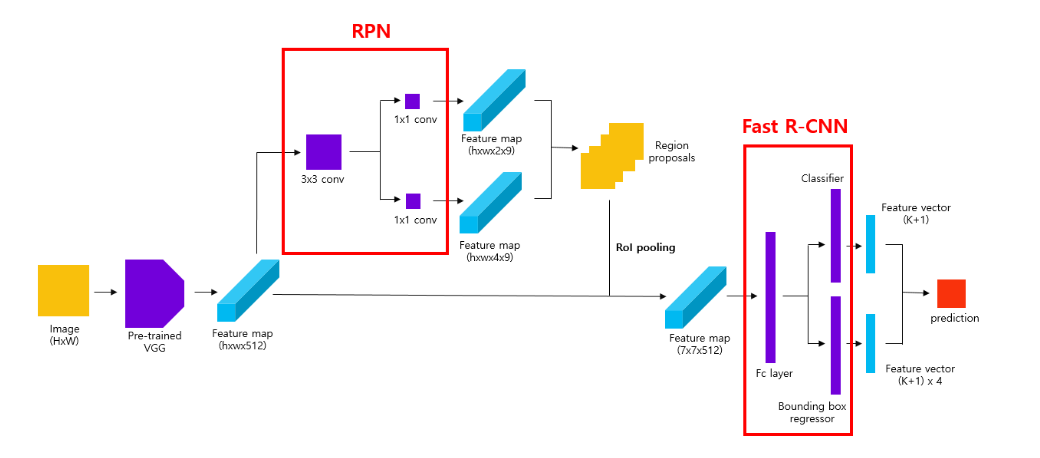

In [107]:
mid_channel = 512
in_channel = 512 # VGG의 output channel이 512
n_anchor = 9

conv1 = nn.Conv2d(in_channel, mid_channel, 3, 1, 1)
reg_layer = nn.Conv2d(mid_channel, n_anchor*4, 1, 1, 0) # 4 : bounding box regressor
cls_layer = nn.Conv2d(mid_channel, n_anchor*2, 1, 1, 0) # 2 : object 여부

In [108]:
# 각 위치별 (50,50) regression과 classification 예측 값 얻음
x = conv1(output_map)
anchor_pred_format_locations = reg_layer(x)
anchor_pred_scores = cls_layer(x)

print(anchor_pred_format_locations.shape) # torch.Size([1, 36, 50, 50])
print(anchor_pred_scores.shape) # torch.Size([1, 18, 50, 50])

torch.Size([1, 36, 50, 50])
torch.Size([1, 18, 50, 50])


In [109]:
# torch.permute : 차원 순서 바꾸기
# 텐서의 shape을 조작하는 과정에서 메모리 저장 상태가 변경되는데,
# 이때 torch.contiguous() 을 사용하여 contiguous=True 인 상태로 변경해주어야 한다.
anchor_pred_format_locations = anchor_pred_format_locations.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
anchor_pred_scores = anchor_pred_scores.permute(0, 2, 3, 1).contiguous().view(1, -1, 2)
objectness_pred_scores = anchor_pred_scores[:, :, 1]

In [110]:
# bbox를 통해 만든 ground truth 값
print(anchor_target_labels.shape)
print(anchor_target_format_locations.shape)
# RPN으로 예측한 값
print(anchor_pred_scores.shape)
print(anchor_pred_format_locations.shape)

# numpy 에서 torch로 변환
gt_rpn_format_locs = torch.from_numpy(anchor_target_format_locations)
gt_rpn_scores = torch.from_numpy(anchor_target_labels)

rpn_format_locs = anchor_pred_format_locations[0]
rpn_scores = anchor_pred_scores[0]

(22500,)
(22500, 4)
torch.Size([1, 22500, 2])
torch.Size([1, 22500, 4])


In [111]:
# Cross Entropy loss
# Object 여부 판단
rpn_cls_loss = F.cross_entropy(rpn_scores, gt_rpn_scores.long(), ignore_index=-1)
print(rpn_cls_loss)

# Location loss
# 실제 object 인 것만 masking 하여 loss 계산
mask = gt_rpn_scores > 0
mask_target_format_locs = gt_rpn_format_locs[mask]
mask_pred_format_locs = rpn_format_locs[mask]

print(mask_target_format_locs.shape)
print(mask_pred_format_locs.shape)

x = torch.abs(mask_target_format_locs - mask_pred_format_locs)
rpn_loc_loss = ((x<0.5).float()*(x**2)*0.5 + (x>0.5).float()*(x-0.5)).sum()
print(rpn_loc_loss)

tensor(0.6890, grad_fn=<NllLossBackward0>)
torch.Size([62, 4])
torch.Size([62, 4])
tensor(5.6369, grad_fn=<SumBackward0>)


In [112]:
rpn_lambda = 10
N_reg = mask.float().sum()

rpn_loss = rpn_cls_loss + rpn_lambda / N_reg * rpn_loc_loss
print(rpn_loss)

tensor(1.5982, grad_fn=<AddBackward0>)


## Fast R-CNN

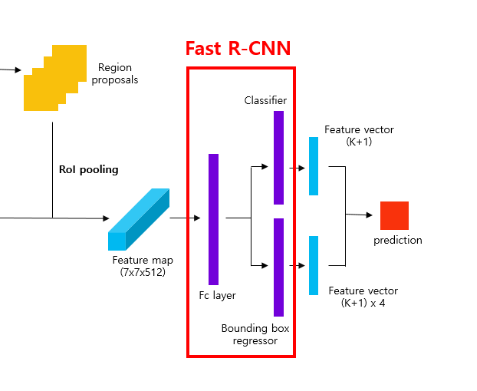

### Fast R-CNN에서 학습할 RPN에서 구한 Proposal 남기기


In [113]:
# NMS에 적용할 threshold
# NMS로 같은 클래스 정보를 가지는 box끼리 IoU를 비교해 중복 제거
nms_threshold = 0.7
n_train_pre_nms = 12000 # nms 이전
n_train_post_nms = 2000 # nms 이후
min_size = 16

In [114]:
print(anchors.shape) # 22500, 4
print(anchor_pred_format_locations.shape) # 22500, 4

# 예측한 location을 anchor를 통해 rois 로 바꿔줌
# (y1, x1, y2, x2)
rois = deformat_loc(anchors, anchor_pred_format_locations[0].data.numpy())
print(rois.shape) # 22500, 4

print(rois)

(22500, 4)
torch.Size([1, 22500, 4])
(22500, 4)
[[ -33.87011264  -74.26168754   55.30798468  106.9706566 ]
 [ -67.52891064  -59.92791557   63.40163136   70.93229866]
 [ -59.21347155  -26.73073221  109.5633446    59.47352125]
 ...
 [ 616.40048709  439.61036414  971.50190378 1187.65173988]
 [ 573.64809227  556.76087952 1054.16121483 1058.0738678 ]
 [ 474.41566053  637.34015545 1158.95812226  979.33702854]]


In [115]:
image_size = [800, 800]
# 이미지를 벗어나는 값 조정
rois[:, 0:4:2] = np.clip(rois[:, 0:4:2], a_min=0, a_max=image_size[0])
rois[:, 1:4:2] = np.clip(rois[:, 1:4:2], a_min=0, a_max=image_size[1])
print(rois)

[[  0.           0.          55.30798468 106.9706566 ]
 [  0.           0.          63.40163136  70.93229866]
 [  0.           0.         109.5633446   59.47352125]
 ...
 [616.40048709 439.61036414 800.         800.        ]
 [573.64809227 556.76087952 800.         800.        ]
 [474.41566053 637.34015545 800.         800.        ]]


In [116]:
h = rois[:, 2] - rois[:, 0]
w = rois[:, 3] - rois[:, 1]
# box의 크기(가로 세로 길이)가 16보다 작은 것들 제외
valid_index = np.where((h>min_size)&(w>min_size))[0]
valid_rois = rois[valid_index]
valid_scores = objectness_pred_scores[0][valid_index].data.numpy()

In [117]:
# object socre 순서로 정렬
valid_score_order = valid_scores.ravel().argsort()[::-1]

pre_train_valid_score_order = valid_score_order[:n_train_pre_nms]
pre_train_valid_rois = valid_rois[pre_train_valid_score_order]
pre_train_valid_scores = valid_scores[pre_train_valid_score_order]

print(pre_train_valid_rois.shape) # 12000, 4
print(pre_train_valid_scores.shape) # 12000,
print(pre_train_valid_score_order.shape) # 12000,

(12000, 4)
(12000,)
(12000,)


In [118]:
# 12000개를 nms에 적용
keep_index = nms(pre_train_valid_rois, pre_train_valid_scores, nms_threshold)
# nms를 적용한 roi (최대 2000개까지 남김)
post_train_valid_rois = pre_train_valid_rois[keep_index][:n_train_post_nms]
post_train_valid_scores = pre_train_valid_scores[keep_index][:n_train_post_nms]
print(post_train_valid_rois.shape) 
print(post_train_valid_scores.shape) 

(1474, 4)
(1474,)


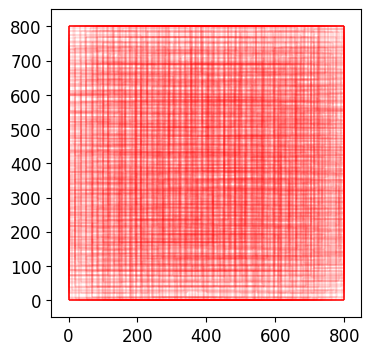

In [119]:
# nms 를 적용하여 남긴 roi
plt.rcParams['figure.figsize'] = (4, 4)
fig, ax = plt.subplots()

for (y1, x1, y2, x2) in post_train_valid_rois:
    x, y = x1, y1
    w = np.abs(x2 - x1)
    h = np.abs(y2 - y1)
    ax.add_patch(
        patches.Rectangle(
            (x, y), w, h,
            edgecolor='red',
            linewidth=0.1,
            fill=False))

ax.set_xlim(-50, 850)
ax.set_ylim(-50, 850)
plt.show()

### Fast R-CNN을 위한 Ground truth 만들기

In [120]:
n_sample = 128
pos_ratio = 0.25
pos_iou_thresh = 0.5
neg_iou_thresh_hi = 0.5
neg_iou_thresh_lo = 0.0

In [121]:
# 위에서 구한 roi와 bbox를 비교아혀 IoU 계산
ious = bbox_IoU(post_train_valid_rois, bbox)
print(ious.shape)

(1474, 2)


In [122]:
bbox_assignments = ious.argmax(axis=1)
roi_max_ious = ious.max(axis=1)
# index 0과 1에 있는 iou 값을 비교하게 되는데 0 이 크면 6, 1이 크면 8로 labeling
# 맨 위에 있는 Feature Extraction 부분을 보면 왜 6, 8로 labelling 했는지 알 수 있음
roi_target_labels = labels[bbox_assignments]
print(roi_target_labels.shape) # 2000

torch.Size([1474])


In [123]:
# 위에서 구한 roi가 모두 target일 수는 없기 때문에 sampling 진행
total_n_pos = len(np.where(roi_max_ious >= pos_iou_thresh)[0])
n_pos_sample = n_sample*pos_ratio if total_n_pos > n_sample*pos_ratio else total_n_pos
n_neg_sample = n_sample - n_pos_sample

print(n_pos_sample)
print(n_neg_sample) 

17
111


In [124]:
pos_index = np.where(roi_max_ious >= pos_iou_thresh)[0]
pos_index = np.random.choice(pos_index, size=n_pos_sample, replace=False)

neg_index = np.where((roi_max_ious < neg_iou_thresh_hi) & (roi_max_ious > neg_iou_thresh_lo))[0]
neg_index = np.random.choice(neg_index, size=n_neg_sample, replace=False)

print(pos_index.shape) 
print(neg_index.shape) 

(17,)
(111,)


In [125]:
keep_index = np.append(pos_index, neg_index)
post_sample_target_labels = roi_target_labels[keep_index].data.numpy()
post_sample_target_labels[len(pos_index):] = 0
post_sample_rois = post_train_valid_rois[keep_index]

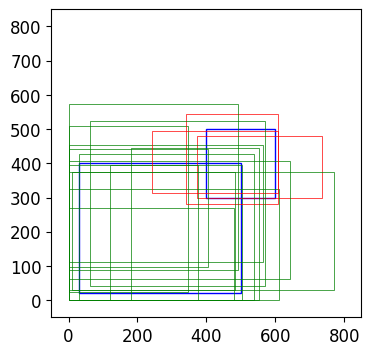

In [126]:
# 파란색 : target (label 6 , 8 의 target box)
# 초록색은 라벨 6을 위한 roi box, 빨간색은 라벨 8을 위한 roi box
plt.rcParams['figure.figsize'] = (4, 4)
fig, ax = plt.subplots()

for (y1, x1, y2, x2) in bbox:
    x, y = x1, y1
    w = np.abs(x2 - x1)
    h = np.abs(y2 - y1)
    ax.add_patch(
        patches.Rectangle(
            (x, y), w, h,
            edgecolor='blue',
            linewidth=1,
            fill=False))

for i, (y1, x1, y2, x2) in enumerate(post_sample_rois):
    x, y = x1, y1
    w = np.abs(x2 - x1)
    h = np.abs(y2 - y1)
    if post_sample_target_labels[i] == 6 :
        ax.add_patch(
            patches.Rectangle(
                (x, y), w, h,
                edgecolor='green',
                linewidth=0.5,
                fill=False))
    elif post_sample_target_labels[i] == 8 :
        ax.add_patch(
            patches.Rectangle(
                (x, y), w, h,
                edgecolor='red',
                linewidth=0.5,
                fill=False))

ax.set_xlim(-50, 850)
ax.set_ylim(-50, 850)
plt.show()

In [127]:
# Fast R-CNN과 비교를 위한 loc 형태로 변환
post_sample_bbox = bbox[bbox_assignments[keep_index]]
post_sample_format_rois = format_loc(anchors=post_sample_rois, base_anchors=post_sample_bbox.data.numpy())
print(post_sample_format_rois.shape)

(128, 4)


### Fast R-CNN

In [128]:
# roi를 numpy 에서 torch 변환
rois = torch.from_numpy(post_sample_rois).float()
print(rois.shape) # 128, 4

torch.Size([128, 4])


RoI Pooling

In [129]:
size = (7, 7)
adaptive_max_pool = nn.AdaptiveMaxPool2d(size)

# 고정된 크기로 추출
# 각 roi들은 각각 (50,50) 공간에 mapping
rois.mul_(1/16.0)
rois = rois.long()

In [130]:
output = []
num_rois = len(rois)
# 기존 output_map : torch.Size([1, 512, 50, 50])
# roi : (y1, x1, y2, x2)
# 각각의 roi를 pooling layer를 거쳐 고정된 크기로 추출
for roi in rois:
    roi_feature = output_map[..., roi[0]:roi[2]+1, roi[1]:roi[3]+1]
    output.append(adaptive_max_pool(roi_feature))
output = torch.cat(output, 0)
print(output.shape) 

torch.Size([128, 512, 7, 7])


In [131]:
output_ROI_pooling = output.view(output.size(0), -1)
print(output_ROI_pooling.shape)

torch.Size([128, 25088])


Fast R-CNN Loss

In [132]:
roi_head = nn.Sequential(nn.Linear(25088, 4096),
                        nn.Linear(4096, 4096))

cls_loc = nn.Linear(4096, 21*4) # 21 : class(20) + background(1), 4: 좌표
cls_loc.weight.data.normal_(0, 0.01)
cls_loc.bias.data.zero_()

cls_score = nn.Linear(4096, 21) # 21 : class(20) + background(1)
cls_score.weight.data.normal_(0, 0.01)
cls_score.bias.data.zero_()

x = roi_head(output_ROI_pooling)
roi_cls_loc = cls_loc(x)
roi_cls_score = cls_score(x)

print(roi_cls_loc.shape, roi_cls_score.shape)

torch.Size([128, 84]) torch.Size([128, 21])


In [133]:
# 예측값
print(roi_cls_loc.shape) 
print(roi_cls_score.shape)

torch.Size([128, 84])
torch.Size([128, 21])


In [134]:
# 실제값
print(post_sample_format_rois.shape) # 128, 4
print(post_sample_target_labels.shape) # 128, 

gt_roi_cls_loc = torch.from_numpy(post_sample_format_rois).float()
gt_roi_cls_label = torch.from_numpy(post_sample_target_labels).long()

(128, 4)
(128,)


In [135]:
# cross entropy 적용
roi_cls_loss = F.cross_entropy(roi_cls_score, gt_roi_cls_label)
print(roi_cls_loss)

tensor(3.0280, grad_fn=<NllLossBackward0>)


In [136]:
num_roi = roi_cls_loc.size(0)
roi_cls_loc = roi_cls_loc.view(-1, 21, 4)
roi_cls_loc = roi_cls_loc[torch.arange(num_roi), gt_roi_cls_label]
print(roi_cls_loc.shape)

# label이 background가 아닌 것들만 masking 처리하여 계산
mask = gt_roi_cls_label>0
mask_loc_pred = roi_cls_loc[mask]
mask_loc_target = gt_roi_cls_loc[mask]

print(mask_loc_pred.shape) # 10, 4
print(mask_loc_target.shape) # 10, 4

x = torch.abs(mask_loc_pred-mask_loc_target)
roi_loc_loss = ((x<0.5).float()*x**2*0.5 + (x>0.5).float()*(x-0.5)).sum()
print(roi_loc_loss)

torch.Size([128, 4])
torch.Size([17, 4])
torch.Size([17, 4])
tensor(1.2067, grad_fn=<SumBackward0>)


In [137]:
roi_lambda = 10
N_reg = (gt_roi_cls_label>0).float().sum()
roi_loss = roi_cls_loss + roi_lambda / N_reg * roi_loc_loss
print(roi_loss)

tensor(3.7378, grad_fn=<AddBackward0>)


In [138]:
total_loss = rpn_loss + roi_loss
print(total_loss)

tensor(5.3360, grad_fn=<AddBackward0>)
